<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/vision_project_FER_2013__final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell loads the `fer2013` dataset from KaggleHub and stores its path.

In [1]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [2]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization #for CNN model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix  #for training report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential   #for training model
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os



#Visualizing Data


This cell defines the file paths for the training and testing datasets based on the previously loaded KaggleHub path.

In [3]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

Existing Classes : ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


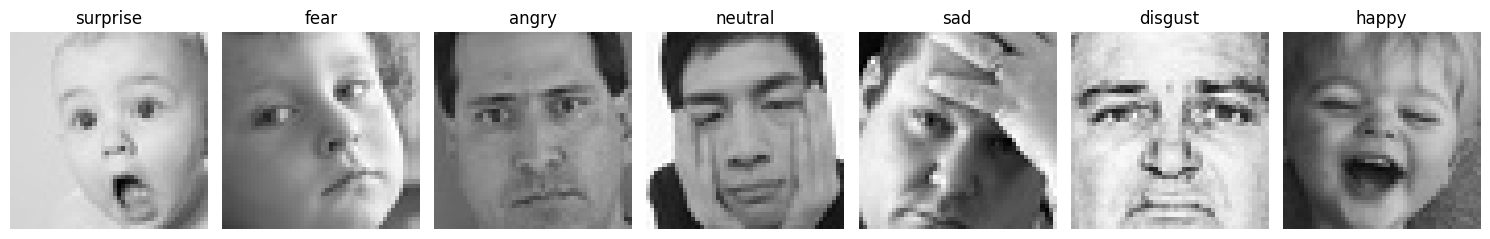

train_counts: 



,Train Count
surprise,3171
fear,4097
angry,3995
neutral,4965
sad,4830
disgust,436
happy,7215



test_counts:


,Test Count
surprise,831
fear,1024
angry,958
neutral,1233
sad,1247
disgust,111
happy,1774


total train image : 28709
total test image : 7178


In [4]:
classes=os.listdir(train_path)
print("Existing Classes :",classes)

plt.figure(figsize=(15,5))
for index,emotion in enumerate(classes):
  emotion_path=os.path.join(train_path,emotion)
  rand_image=random.choice(os.listdir(emotion_path))
  image_path=os.path.join(emotion_path,rand_image)
  image=cv2.imread(image_path)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.subplot(1, len(classes), index+1)
  plt.imshow(img)
  plt.title(emotion)
  plt.axis("off")

plt.tight_layout()
plt.show()


# Function to count images per class in a given path
def count_images_per_class(base_path, classes):
    counts = {}
    for emotion in classes:
        emotion_dir = os.path.join(base_path, emotion)
        if os.path.exists(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
        else:
            counts[emotion] = 0
    return counts

# Count images for training set
train_counts = count_images_per_class(train_path, classes)
train_df = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count'])

# Count images for testing set
test_counts = count_images_per_class(test_path, classes)
test_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count'])

# Display the summary in a formatted way
print("train_counts: \n")
display(train_df)
print("\ntest_counts:")
display(test_df)

print("total train image :",train_df['Train Count'].sum())
print("total test image :",test_df['Test Count'].sum())

# Images shape

In [5]:
print(f"Image dimensions: {img.shape}") # Output from the previously executed cell


Image dimensions: (48, 48, 3)


### Dataset Class Distribution Visualization

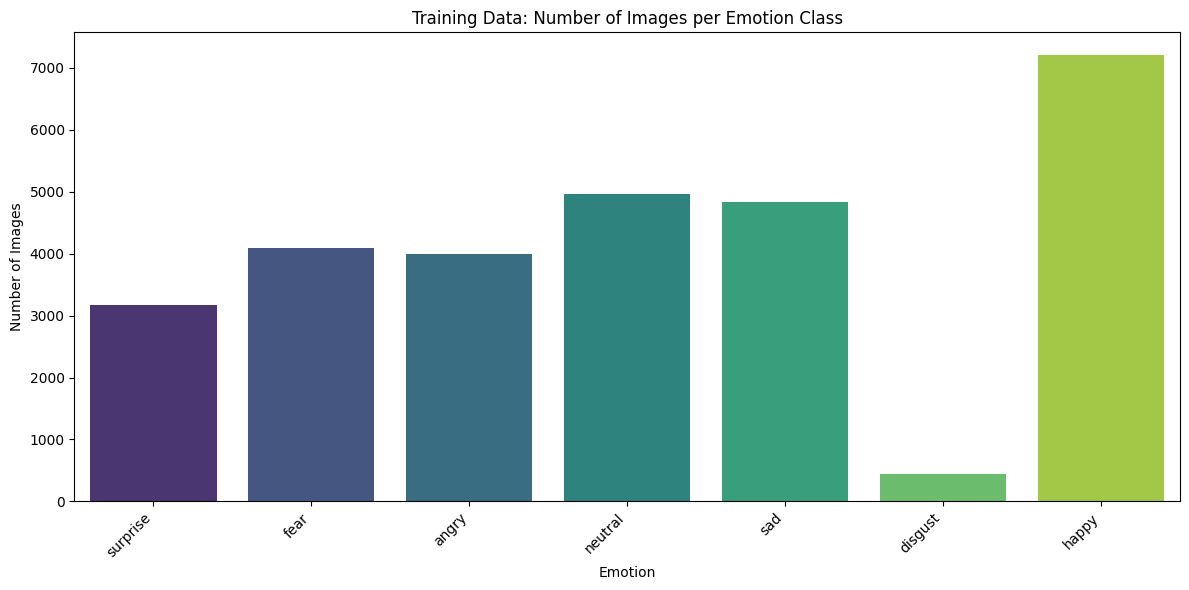

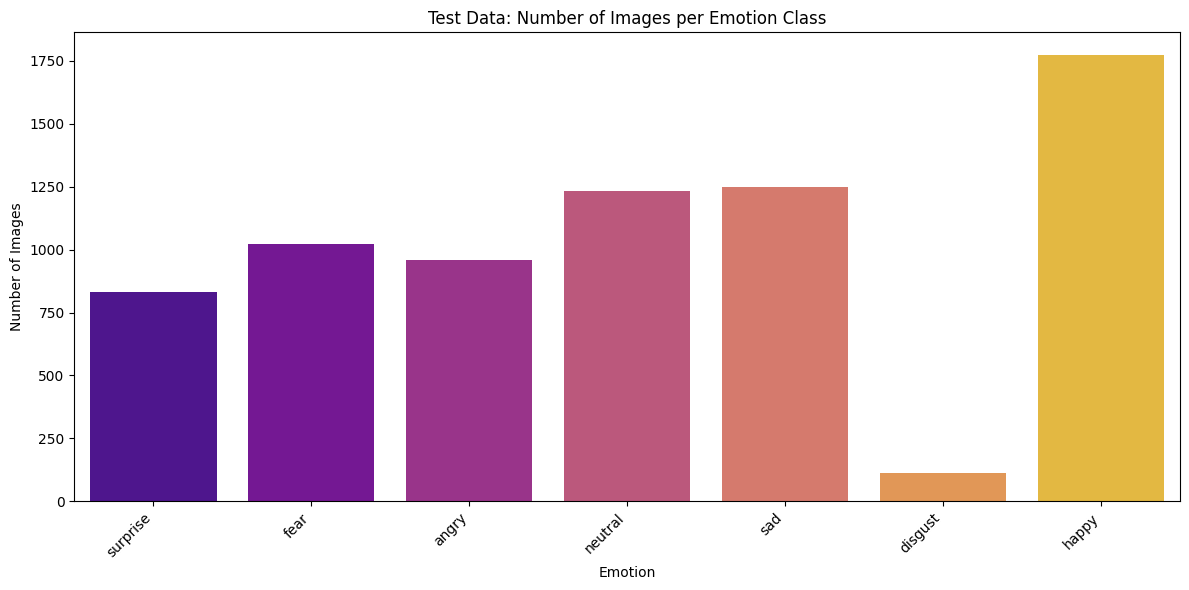

In [6]:
# Visualize class distribution for training set
plt.figure(figsize=(12, 6))
sns.barplot(x=train_df.index, y='Train Count', data=train_df, palette='viridis', hue=train_df.index, legend=False)
plt.title('Training Data: Number of Images per Emotion Class')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize class distribution for testing set
plt.figure(figsize=(12, 6))
sns.barplot(x=test_df.index, y='Test Count', data=test_df, palette='plasma', hue=test_df.index, legend=False)
plt.title('Test Data: Number of Images per Emotion Class')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Data Augmentation

In [7]:
# Image parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 128
EPOCHS = 50
NUM_CLASSES = 7

In [8]:
# Data generators with augmentation for trainingt
train_datagen=ImageDataGenerator(
    rescale=1./255,       #Normalization
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

In [9]:
# Data generators with Normalizing for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Loading training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [11]:
# Loading validation data
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


In [12]:
# Loading test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    color_mode='grayscale', # Changed from 'grayscale' to 'rgb'
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Found 7178 images belonging to 7 classes.


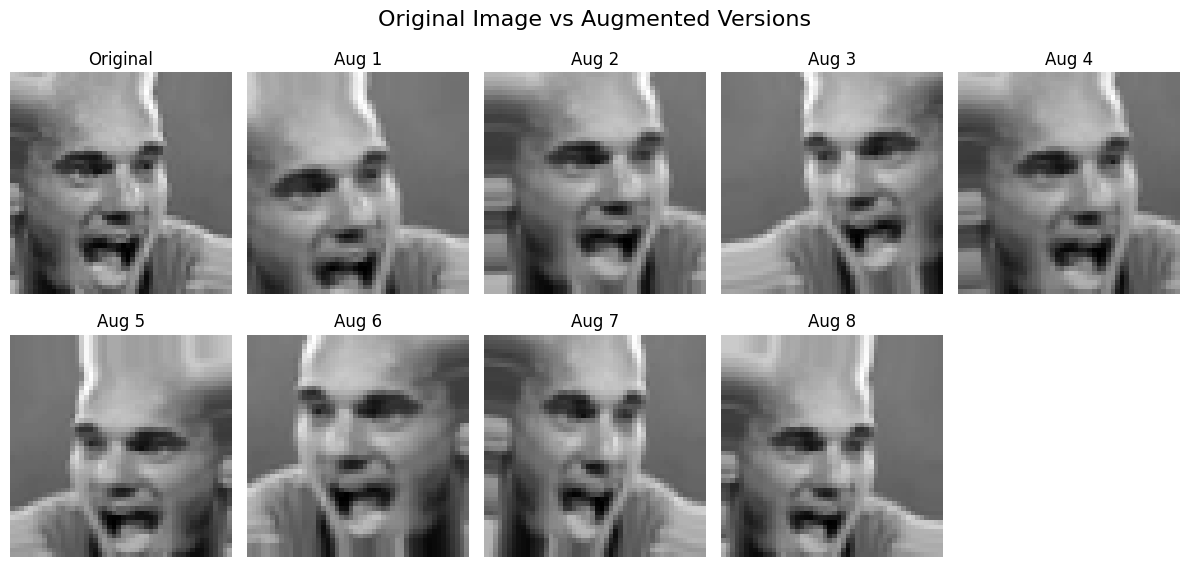

In [13]:

# Take one image
images, labels = next(train_generator)
img = images[0]

# Plot original + augmented versions
plt.figure(figsize=(12, 6))
plt.subplot(2, 5, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

# Show 8 augmented versions
for i in range(8):
    augmented_img = train_datagen.random_transform(img)
    plt.subplot(2, 5, i + 2)
    plt.imshow(augmented_img, cmap='gray')
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.suptitle("Original Image vs Augmented Versions", fontsize=16)
plt.tight_layout()
plt.show()



#Building the CNN Model

In [14]:
# Building a deeper CNN model
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu',input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

   # Dense layers
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Optimizer

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
# Create a clone of the model for SGD optimizer
from tensorflow.keras.models import clone_model

model_SGD = clone_model(model)
model_SGD.set_weights(model.get_weights())

model_SGD.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
# Create a clone of the model for Adagrad optimizer
from tensorflow.keras.models import clone_model

model_Adagrad = clone_model(model)
model_Adagrad.set_weights(model.get_weights())

model_Adagrad.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,946,055 (37.94 MB)

 Trainable params: 9,939,143 (37.91 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [19]:
#early stop to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [20]:
# We use class weights to address class imbalance since some classes have fewer samples.

# 1. Get the class indices and counts from the training generator
class_lable=train_generator.classes
num_classes=train_generator.num_classes

# 2. Compute class weights
class_weights_array=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(class_lable),y=class_lable)

class_weights = dict(enumerate(class_weights_array))
print("Calculated Class Weights:", class_weights)

Calculated Class Weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


#Model Training

In [21]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 197s 976ms/step - accuracy: 0.1541 - loss: 2.8226 - val_accuracy: 0.0152 - val_loss: 5.7945 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - accuracy: 0.1677 - loss: 2.1984 - val_accuracy: 0.1956 - val_loss: 1.8939 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.1850 - loss: 2.0903 - val_accuracy: 0.1681 - val_loss: 2.0000 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.2159 - loss: 1.9687 - val_accuracy: 0.2494 - val_loss: 1.8272 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 214ms/step - accuracy: 0.2579 - loss: 1.8172 - val_accuracy: 0.2547 - val_loss: 1.9145 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.2925 - loss: 1.7682 - val_accuracy: 0.3853 - val_loss: 1.5767 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.

In [26]:
#fit model with SGD optimizer
history_SGD=model_SGD.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 66s 309ms/step - accuracy: 0.6742 - loss: 0.8084 - val_accuracy: 0.5910 - val_loss: 1.1176 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.6880 - loss: 0.7477 - val_accuracy: 0.6250 - val_loss: 1.0333 - learning_rate: 0.0100
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.6861 - loss: 0.7672 - val_accuracy: 0.5999 - val_loss: 1.1096 - learning_rate: 0.0100
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.6805 - loss: 0.7808 - val_accuracy: 0.5614 - val_loss: 1.2011 - learning_rate: 0.0100
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.6819 - loss: 0.7765 - val_accuracy: 0.5924 - val_loss: 1.1252 - learning_rate: 0.0100
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.6949 - loss: 0.7506 - val_accuracy: 0.6203 - val_loss: 1.0452 - learning_rate: 0.0100
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.6

In [27]:
#fit model with Adagrad optimizer
history_Adagrad=model_Adagrad.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 317ms/step - accuracy: 0.6937 - loss: 0.7522 - val_accuracy: 0.6342 - val_loss: 0.9859 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 262ms/step - accuracy: 0.6921 - loss: 0.7582 - val_accuracy: 0.6321 - val_loss: 0.9880 - learning_rate: 0.0100
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step - accuracy: 0.6969 - loss: 0.7295 - val_accuracy: 0.6227 - val_loss: 1.0247 - learning_rate: 0.0100
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 261ms/step - accuracy: 0.7005 - loss: 0.7272 - val_accuracy: 0.6366 - val_loss: 0.9811 - learning_rate: 0.0100
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.7041 - loss: 0.7188 - val_accuracy: 0.6384 - val_loss: 0.9935 - learning_rate: 0.0100
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 263ms/step - accuracy: 0.6921 - loss: 0.7423 - val_accuracy: 0.6398 - val_loss: 0.9798 - learning_rate: 0.0100
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 261ms/step - accuracy: 0.7

#Model Evaluation

In [28]:
# Evaluating on test set
test_loss,test_acc=model.evaluate(test_generator)
print("Test Loss:",test_loss)
print("Test Accuracy:",test_acc)

#Evaluating SGD model on test set
test_loss_SGD,test_acc_SGD=model_SGD.evaluate(test_generator)
print("SGD Test Loss:",test_loss_SGD)
print("SGD Test Accuracy:",test_acc_SGD)

# evaluating Adagrad model on test set
test_loss_Adagrad,test_acc_Adagrad=model_Adagrad.evaluate(test_generator)
print("Adagrad Test Loss:",test_loss_Adagrad)
print("Adagrad Test Accuracy:",test_acc_Adagrad)

57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 761ms/step - accuracy: 0.6342 - loss: 1.0125
Test Loss: 0.9648975729942322
Test Accuracy: 0.6540819406509399
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.6375 - loss: 1.0088
SGD Test Loss: 0.9660196304321289
SGD Test Accuracy: 0.6512956023216248
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.6384 - loss: 1.0104
Adagrad Test Loss: 0.9617723822593689
Adagrad Test Accuracy: 0.6568682193756104


In [29]:
# Predictions and metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))

#Predicting and metrics for SGD model
y_pred_SGD = model_SGD.predict(test_generator)
y_pred_classes_SGD = np.argmax(y_pred_SGD, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes_SGD, target_names=train_generator.class_indices.keys()))

#Predicting and metrics for Adagrad model
y_pred_Adagrad = model_Adagrad.predict(test_generator)
y_pred_classes_Adagrad = np.argmax(y_pred_Adagrad, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes_Adagrad, target_names=train_generator.class_indices.keys()))

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step
              precision    recall  f1-score   support

       angry       0.54      0.65      0.59       958
     disgust       0.56      0.63      0.59       111
        fear       0.53      0.42      0.47      1024
       happy       0.91      0.82      0.86      1774
     neutral       0.56      0.71      0.62      1233
         sad       0.59      0.45      0.51      1247
    surprise       0.70      0.83      0.76       831

    accuracy                           0.65      7178
   macro avg       0.63      0.64      0.63      7178
weighted avg       0.66      0.65      0.65      7178

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step
              precision    recall  f1-score   support

       angry       0.53      0.66      0.59       958
     disgust       0.53      0.61      0.57       111
        fear       0.54      0.42      0.48      1024
       happy       0.91      0.81      0.86      1774
     neutral       0.56      0.70      0.62     

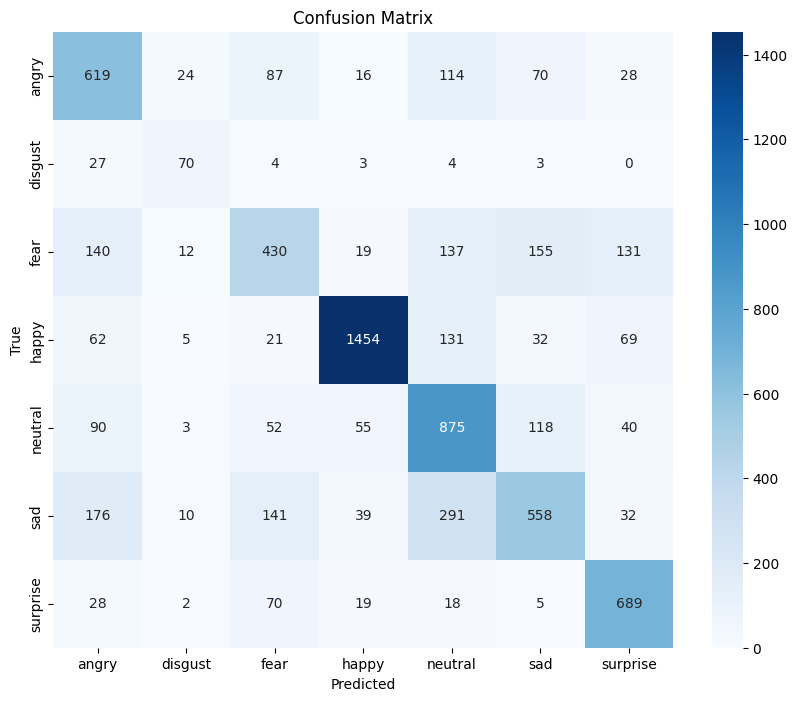

In [30]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



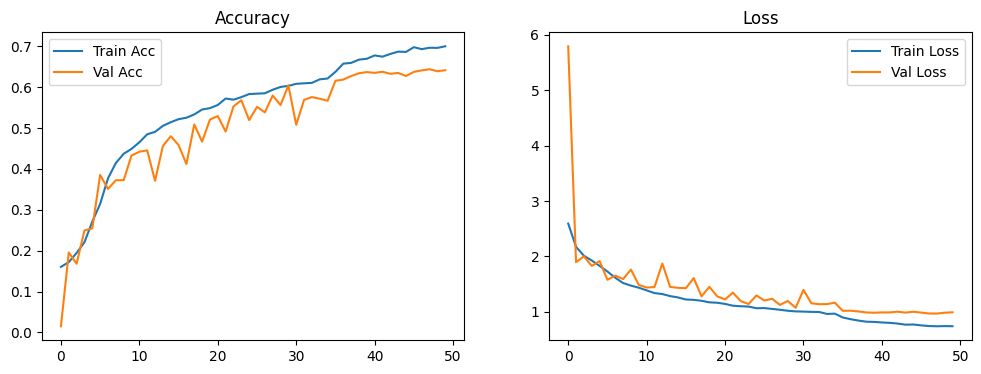

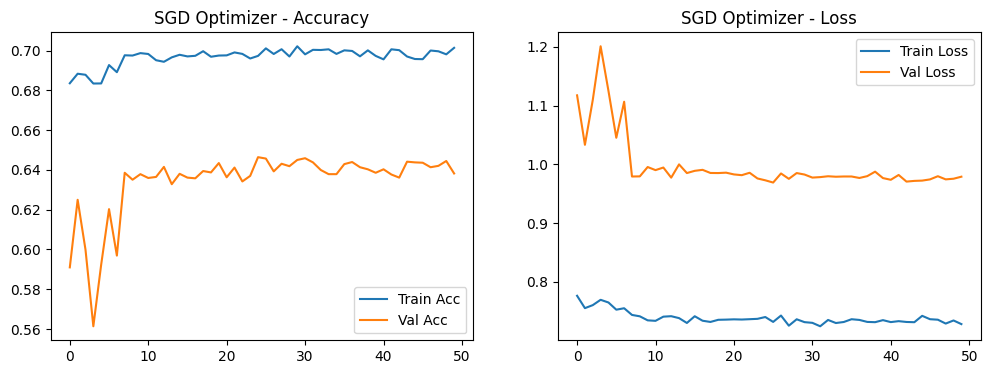

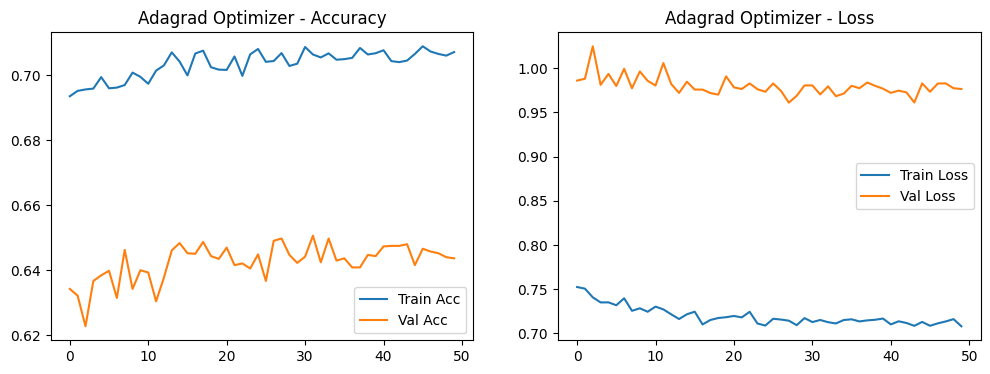

In [31]:
# Plot training & validation accuracy and loss values for Adam optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Plot training & validation accuracy and loss values for SGD optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_SGD.history['accuracy'], label='Train Acc')
plt.plot(history_SGD.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('SGD Optimizer - Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history_SGD.history['loss'], label='Train Loss')
plt.plot(history_SGD.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('SGD Optimizer - Loss')
plt.show()

# Plot training & validation accuracy and loss values for Adagrad optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Adagrad.history['accuracy'], label='Train Acc')
plt.plot(history_Adagrad.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Adagrad Optimizer - Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history_Adagrad.history['loss'], label='Train Loss')
plt.plot(history_Adagrad.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Adagrad Optimizer - Loss')
plt.show()

# Predictions Visualization

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step


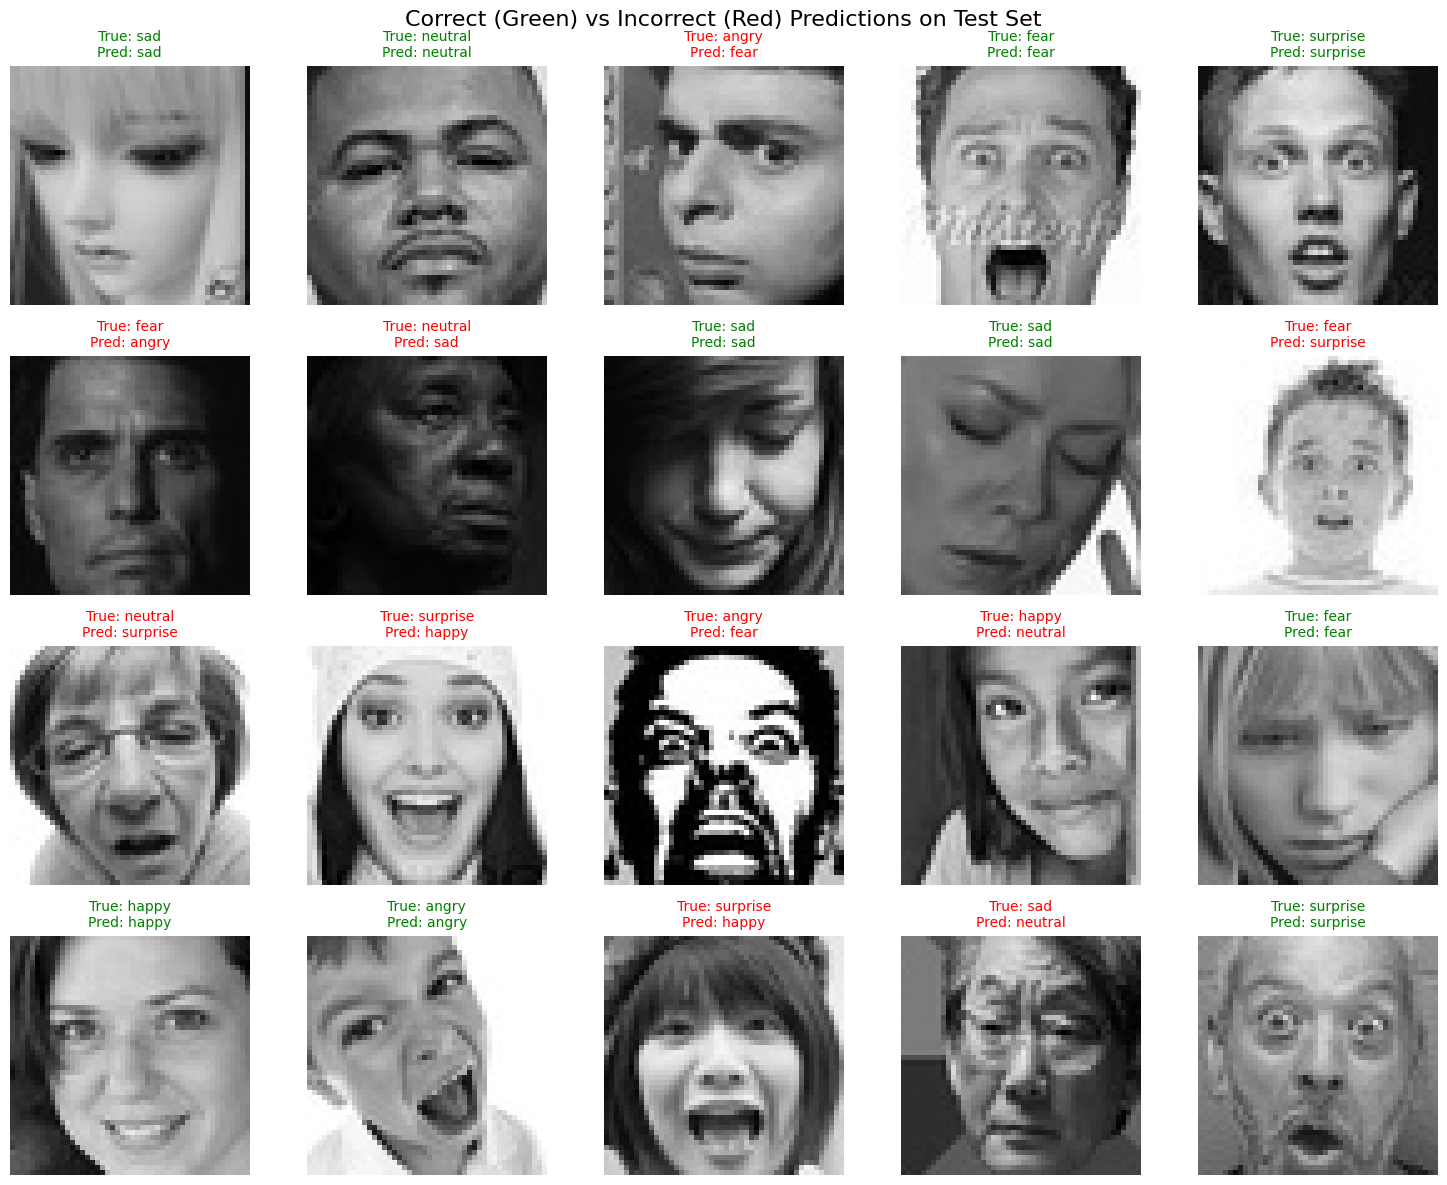

In [35]:
# Visualizing correct & wrong predictions

# File paths from test generator
filenames = test_generator.filenames
n_samples = len(filenames)
n_display = 20  # Number of images to show (mix of correct and wrong)

# True labels and predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Correct and incorrect indices
correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

# Shuffling & selecting some from each
np.random.shuffle(correct_idx)
np.random.shuffle(incorrect_idx)

selected_correct = correct_idx[:n_display // 2]
selected_incorrect = incorrect_idx[:min(len(incorrect_idx), n_display // 2)]

selected_idx = np.concatenate([selected_correct, selected_incorrect])
np.random.shuffle(selected_idx)

# Class names
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 3 * (n_display // 5 + 1)))
for i, idx in enumerate(selected_idx[:n_display]):
    # Load image
    img_path = os.path.join(test_path, filenames[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)  # Ensure same size

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    correct = y_true[idx] == y_pred[idx]

    # Title color: green for correct, red for wrong
    color = 'green' if correct else 'red'
    title = f"True: {true_label}\nPred: {pred_label}"

    plt.subplot(n_display // 5 + 1, 5, i + 1)
    plt.imshow(img)
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("Correct (Green) vs Incorrect (Red) Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model Adam_optimizer
model_adam.save('Emotion_Recognition_model_Adam_optimizer.keras')
print("Model saved to Emotion Recognition_model_Adam_optimizer.keras")

# Save the trained model SGD_optimizer
model_sgd.save('Emotion_Recognition_model_SGD_optimizer.keras')
print("Model saved to Emotion Recognition_model_SGD_optimizer.keras")

# Save the trained model Adagrad_optimizer
model_ada.save('Emotion_Recognition_model_Adagrad_optimizer.keras')
print("Model saved to Emotion Recognition_model_Adagrad_optimizer.keras")